In [29]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,16)

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from line_profiler import LineProfiler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

from DecisionTree2 import Decision_tree
from DecisionTreeMultithread import Decision_tree_multithread

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

In [32]:
class GradientBoostingError(Exception):
    def __init__(self, message=None):
        super(Exception, self).__init__(message)

In [61]:
class Gradient_boosting(BaseEstimator, ClassifierMixin):
    """my gradient boosting binary classification algorithm"""
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, min_impurity=1e-25,
                min_gain=0.0):
        self.h_0 = None
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.min_gain = min_gain
        return
    
    def check_input(self, X, y):
        if not isinstance(X, np.ndarray):
            raise GradientBoostingError("X should be numpy.ndarray")
        if X.ndim != 2:
            raise GradientBoostingError("X.ndim != 2")
        if y.ndim != 1:
            raise GradientBoostingError("y.ndim != 1")
        if not isinstance(y, np.ndarray):
            raise GradientBoostingError("y should be numpy.ndarray")
        unique = np.unique(y)
        if len(unique) != 2:
            raise GradientBoostingError("Only binary classification supported. y should consist of '0' and '1'")
        if 0 not in unique:
            y[y == unique[0]] = 0
            y[y == unique[1]] = 1
        return
    
    def calculate_h_0(self, y):
        y_1_count = np.sum(y)
        y_0_count = y.shape[0] - y_1_count
        return np.log(y_1_count/float(y_0_count))
    
    def sigmoid(self, X):
        return 1.0/(1.0 + np.exp(-X))
    
    def fit(self, X, y):
        self.check_input(X, y)
        self.estimators = []
        self.h_0 = self.calculate_h_0(y)
        
        model_output = self.h_0 * np.ones(y.shape[0])
        sigmoid_output = self.sigmoid(model_output)
        for i in xrange(self.n_estimators):
            antigradient = y - sigmoid_output
            self.estimators.append(Decision_tree(self.max_depth, self.min_samples_split, self.min_impurity,
                                              self.min_gain))
            self.estimators[i].fit(X, antigradient)
            self.estimators[i].add_weights(X, y, sigmoid_output, antigradient)
            model_output += self.learning_rate * self.estimators[i].predict(X)
            sigmoid_output = self.sigmoid(model_output)
        return
        
    def staged_loss(self, X, y):
        if self.h_0 is None:
            raise GradientBoostingError("Model is not fitted")
        prediction = self.h_0 * np.ones(y.shape[0])
        for step in xrange(self.n_estimators):
            prediction += self.learning_rate * self.estimators[step].predict(X)
            loss = log_loss(y, (self.sigmoid(prediction) >= 0.5), normalize=False)
            yield loss
        return
    
    def predict(self, X):
        if self.h_0 is None:
            raise GradientBoostingError("Model is not fitted")
        prediction = (self.h_0 +
                      sum([self.learning_rate * self.estimators[i].predict(X) for i in xrange(self.n_estimators)]))
        return (self.sigmoid(prediction) >= 0.5).astype(int)

In [62]:
def parse_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    X = []
    y = []
    for i in xrange(len(lines)):
        lines[i] = filter(len, lines[i].split("\n"))[0]
        data = lines[i].split(' ')
        X.append(map(float, data[1:]))
        y.append(int(data[0]))
    X_train = np.array(X)
    y_train = np.array(y).astype(int)
    return X_train, y_train

In [63]:
X_train, y_train = parse_file("./dataset/spam.train.txt")
X_test, y_test = parse_file("./dataset/spam.test.txt")

In [65]:
N = 500
clf1 = GradientBoostingClassifier(criterion='mse', n_estimators=N)
clf2 = Gradient_boosting(n_estimators=N)

In [76]:
clf1.fit(X_train, y_train)
target = clf1.predict(X_test)
print accuracy_score(y_test, target)

0.956642800318


In [67]:
clf2.fit(X_train, y_train)
target = clf2.predict(X_test)
print accuracy_score(y_test, target)

0.947991249006


In [68]:
train = clf1.staged_predict(X_train)
test = clf1.staged_predict(X_test)
train_loss_sklearn = []
test_loss_sklearn = []
for y_pred in train:
    train_loss_sklearn.append(log_loss(y_train, y_pred, normalize=False))
for y_pred in test:
    test_loss_sklearn.append(log_loss(y_test, y_pred, normalize=False))

In [69]:
train_loss_my = list(clf2.staged_loss(X_train, y_train))
test_loss_my = list(clf2.staged_loss(X_test, y_test))

In [70]:
x_axis = np.array([i for i in xrange(1, N+1)])
train_loss_sklearn = np.array(train_loss_sklearn)
test_loss_sklearn = np.array(test_loss_sklearn)
train_loss_my = np.array(train_loss_my)
test_loss_my = np.array(test_loss_my)

In [71]:
test_loss_sklearn[499] - test_loss_my[499]

-1243.3703630990203

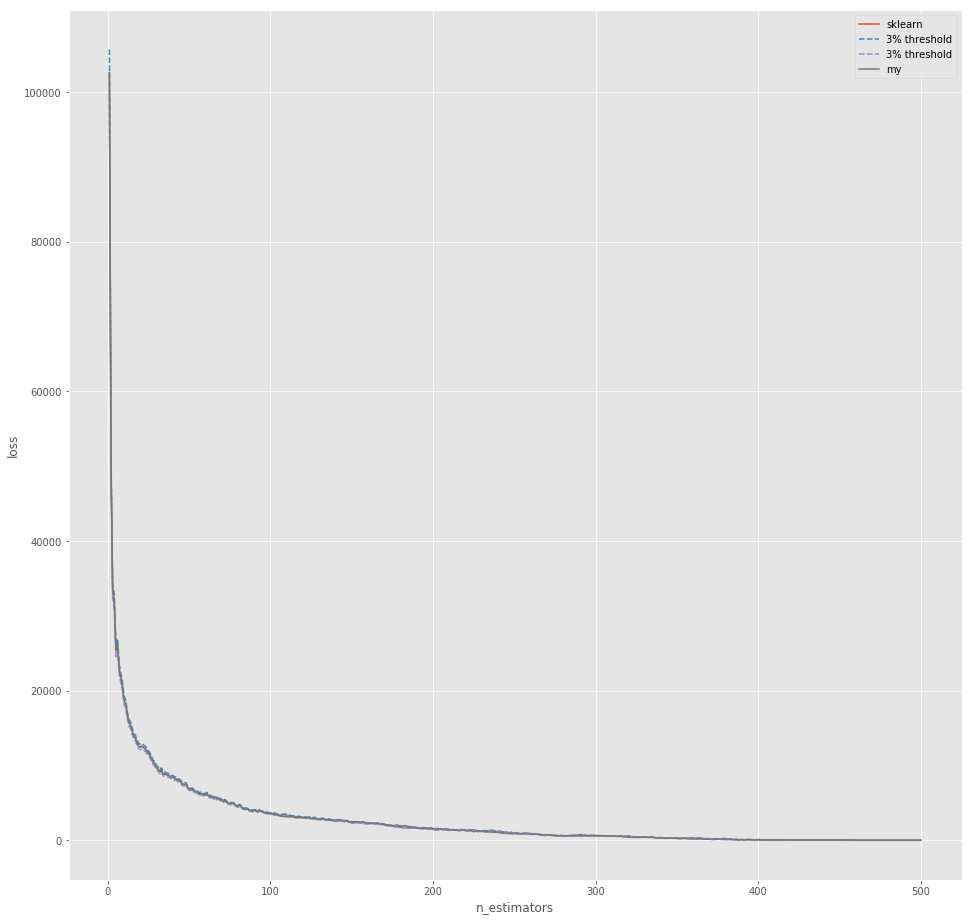

In [72]:
plt.figure()
plt.plot(x_axis, train_loss_sklearn)
plt.plot(x_axis, train_loss_sklearn + 0.03*train_loss_sklearn, ls='--')
plt.plot(x_axis, train_loss_sklearn - 0.03*train_loss_sklearn, ls='--')
plt.plot(x_axis, train_loss_my)
plt.xlabel('n_estimators')
plt.ylabel('loss')
plt.legend(['sklearn', '3% threshold', "3% threshold", 'my'])
plt.show()

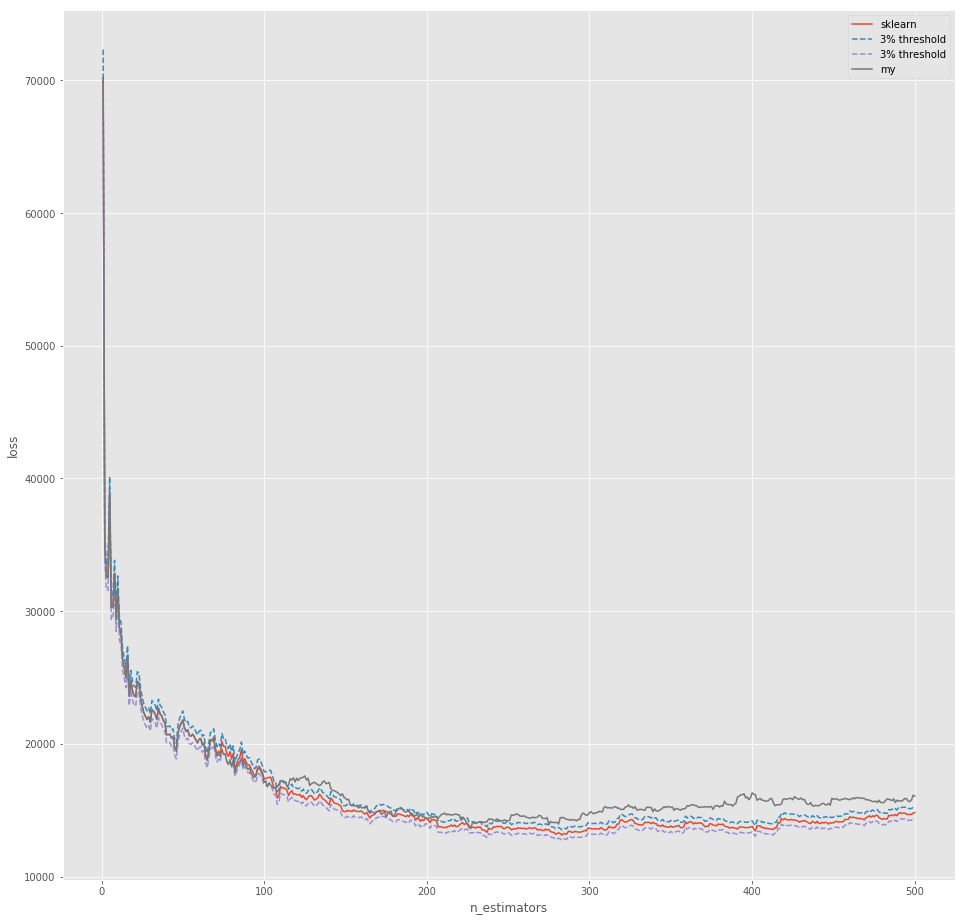

In [73]:
plt.figure()
plt.plot(x_axis, test_loss_sklearn)
plt.plot(x_axis, test_loss_sklearn + 0.03 * test_loss_sklearn, ls='--')
plt.plot(x_axis, test_loss_sklearn - 0.03 * test_loss_sklearn, ls='--')
plt.plot(x_axis, test_loss_my)
plt.xlabel('n_estimators')
plt.ylabel('loss')
plt.legend(['sklearn', "3% threshold", "3% threshold",'my'])
plt.show()

In [74]:
#ДОП ЗАДАЧА: DArt